# SED fitting using eazy-py on each node using MultiThreads

### install eazy-py from https://github.com/gbrammer/eazy-py
- For templates and filters, https://github.com/gbrammer/eazy-photoz/

### what you need: 
- premade_data_path
- input_catalog_path
- output_data_path

# Basic Packages

In [1]:
#!pip list |grep pyarrow

In [2]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import numpy as np
from astropy.table import Table
from matplotlib.ticker import MultipleLocator
import pandas as pd

from astropy.utils.exceptions import AstropyWarning
import warnings

pd.set_option('display.max_rows', 300)
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

In [3]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [5]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [6]:
!pip list |grep eazy

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
eazy                      0.6.8               


# Input Files of RefCat 

> `parquet` files on `hadoop file system`. <br> 
Unfortunately, the **parquet** file is not a **dataframe** but an **astropy table**. 

### Hadoop File System

In [7]:
hdfsheader = 'hdfs://spark00:54310'
workpath = '/user/shong/work/sedfit/spherex/data/temp/'
datapath = '/user/shong/data/spherex/eazypy-input/'

## Pandas Dataframe for the Catalog File List 

In [8]:
!pwd

/home/shong/work/sed-fit/pyspark-eazypy/notebook


In [9]:
!ls /home/shong/work/sed-fit/pyspark-eazypy/data

Gaia_EDR3.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.fits
refcatlist.parquet
SPHEREx_RefCat.BandsInfo.fits


In [10]:
pdf = pq.read_table('/home/shong/work/sed-fit/pyspark-eazypy/data/refcatlist.parquet').to_pandas()

In [11]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    12288 non-null  object 
 1   size    12288 non-null  float64
 2   irank   12288 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 240.1+ KB


In [12]:
pdf["size"].describe()

count    12288.000000
mean        72.990726
std         52.957251
min         18.771200
25%         50.088500
50%         60.941500
75%         74.298100
max        572.447000
Name: size, dtype: float64

In [13]:
pdf.head()

,name,size,irank
0,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,18.7712,1
1,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,19.4544,2
2,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.1404,3
3,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.6769,4
4,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.8368,5


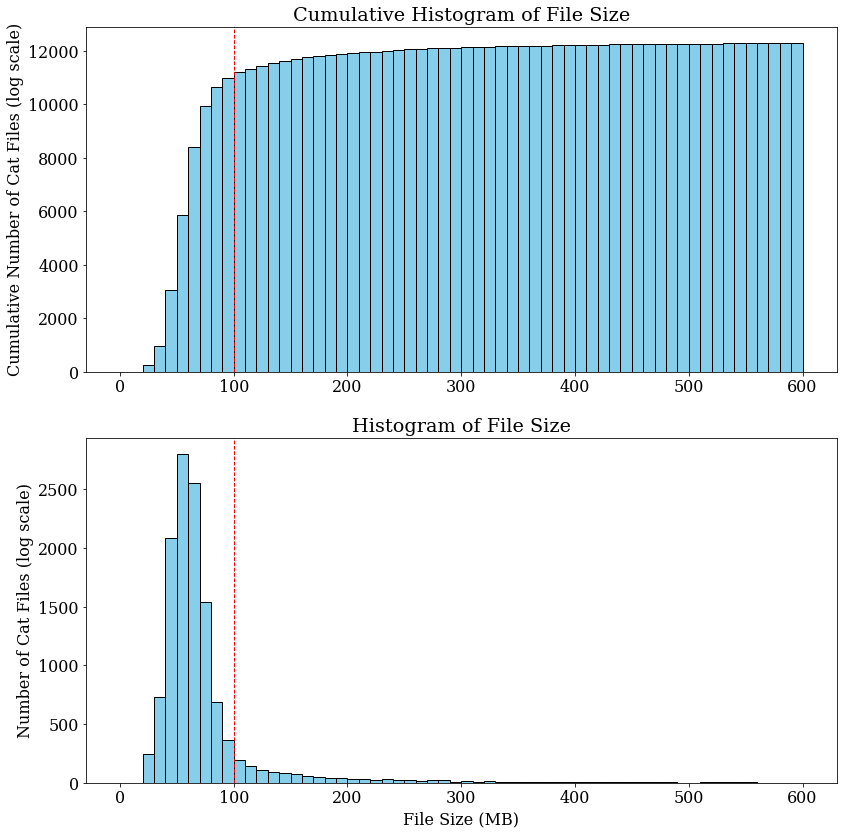

In [14]:
# Set the minimum and maximum values for the x-axis
x_min = 0
x_max = 600  # Adjust this value according to your data

# Create a figure with two subplots vertically arranged
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot the second histogram (cumulative frequency histogram)
axs[0].hist(pdf['size'], bins=60, range=(x_min, x_max), cumulative=True, color='skyblue', edgecolor='black')
axs[0].set_title('Cumulative Histogram of File Size')
axs[0].set_ylabel('Cumulative Number of Cat Files (log scale)')

# Plot the vertical line at size=100 for the first histogram
axs[0].axvline(x=100, color='red', linestyle='dashed', linewidth=1)

# Plot the first histogram (frequency histogram)
axs[1].hist(pdf['size'], bins=60, range=(x_min, x_max), color='skyblue', edgecolor='black')
#axs[1].set_yscale('log')  # Set y-axis to log scale
axs[1].set_title('Histogram of File Size')
axs[1].set_ylabel('Number of Cat Files (log scale)')
# Plot the vertical line at size=100 for the first histogram
axs[1].axvline(x=100, color='red', linestyle='dashed', linewidth=1)
axs[1].set_xlabel('File Size (MB)')

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG file
#plt.savefig('catfile_stats.png')

# Show the plot
plt.show()

> Most of 12+k files are less than 100 MB. <br> 
Hence, our running time should be determined by the performance on these 11k small catalog files.

# Generate EazyPy Input Catalogs from RefCat

### Generate Full Path Names for RefCat

#### HDFS path

In [15]:
incatlist = [hdfsheader+datapath+x for x in pdf['name'].values.tolist()]

In [16]:
incatlist[0]

'hdfs://spark00:54310/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030.parquet'

In [17]:
len(incatlist)

12288

#### Raid5 Mount Path

In [18]:
raidpath = '/mnt/raid5/yyang/SPHEREx_RefCat/'

In [19]:
incatlist = [raidpath+x for x in pdf['name'].values.tolist()]

In [20]:
incatlist[0]

'/mnt/raid5/yyang/SPHEREx_RefCat/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030.parquet'

In [21]:
len(incatlist)

12288

#### Input EazyPy Catalog List in Raid5 

In [22]:
ineazyraidpath = '/mnt/raid5/shong/eazypy-inputcat/'

In [23]:
ineazylist = [ineazyraidpath+x.rsplit('.',1)[0]+"_eazyinput.cat" for x in pdf['name'].values.tolist()]

In [24]:
ineazylist[0]

'/mnt/raid5/shong/eazypy-inputcat/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

#### Input EazyPy Catalog List

In [25]:
ineazypath = '/user/shong/data/spherex/eazypy-input/'

In [26]:
ineazylist = [hdfsheader+ineazypath+x.rsplit('.',1)[0]+"_eazyinput.cat" for x in pdf['name'].values.tolist()]

In [27]:
ineazylist[0]

'hdfs://spark00:54310/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

In [28]:
infinallist = [ineazypath+x.rsplit('.',1)[0]+"_eazyinput.cat" for x in pdf['name'].values.tolist()]

In [29]:
infinallist[0]

'/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

In [30]:
infinallist[-1]

'/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_007313_eazyinput.cat'

In [31]:
len(infinallist)

12288

# Load the pre-made template file

> Key input files: <br> [1] `premade_tempfilt.pickle`: this has all template+grid info for fits 
<br> [2] `zphot.param.default.HONG.eazypy` : default settings. Newly added `params` settings will be overrided on this defaults. <br> [3] `zphot.HONG.translate` : default filter id and real filter transmission curves

In [32]:
!pwd

/home/shong/work/sed-fit/pyspark-eazypy/notebook


In [33]:
premade_data_path = '/home/shong/work/sed-fit/pyspark-eazypy/notebook/'

In [34]:
import pickle

In [35]:
# Skip these lines if you first run ez for building `premade_tempfilt`
with open(premade_data_path+'premade_tempfilt.pickle', 'rb') as rfile:
    premade_tempfilt = pickle.load(rfile)
    
with open(premade_data_path+'premade_prior_file.pickle', 'rb') as rrfile:
    premade_prior_mags, premade_prior_data = pickle.load(rrfile)
    
with open(premade_data_path+'premade_templates.pickle', 'rb') as rrrfile:
    premade_templates = pickle.load(rrrfile)
    
with open(premade_data_path+'premade_param_translate.pickle', 'rb') as rrrrfile:
    premade_param, premade_translate = pickle.load(rrrrfile)

# KASI Modded Functions

#### Define Many KASI Wrapper Functions

In [36]:
# Some Global Variables from the PhotoZ class
TRUE_VALUES = [True, 'y', 'yes', 'Y', 'Yes']

__all__ = ["PhotoZ", "TemplateGrid"]

DEFAULT_UBVJ_FILTERS = [153,154,155,161] # Maiz-Appellaniz & 2MASS

DEFAULT_RF_FILTERS = [270, 274] # UV tophat
DEFAULT_RF_FILTERS += [120, 121] # GALEX
DEFAULT_RF_FILTERS += [156, 157, 158, 159, 160] #SDSS
DEFAULT_RF_FILTERS += [161, 162, 163] # 2MASS

MIN_VALID_FILTERS = 1

NUVRK_FILTERS = [121, 158, 163]

CDF_SIGMAS = np.linspace(-5, 5, 51)

In [37]:
def kasi_set_prior(ez, premade_prior_mags, premade_prior_data):
        """
        Related Settings: PRIOR_FILTER=163 for the current spherex 
        
        Sets 
        input: `prior_mags`, `prior_data`, => catalog independent variables
        output: `prior_mag_cat`, `full_logprior` => catalog dependent 
        
        """
        out_full_logprior = np.zeros((ez.NOBJ, ez.NZ), dtype=ez.ARRAY_DTYPE)
        out_prior_mag_cat = np.zeros(ez.NOBJ, dtype=ez.ARRAY_DTYPE)-1
            
        # prior_raw = np.loadtxt(self.param['PRIOR_FILE'])
        # prior_header = open(self.param['PRIOR_FILE']).readline()
        # 
        # self.prior_mags = np.cast[float](prior_header.split()[2:])
        # self.prior_data = np.zeros((self.NZ, len(self.prior_mags)))
        #                            
        # for i in range(self.prior_data.shape[1]):
        #     self.prior_data[:,i] = np.interp(self.zgrid, prior_raw[:,0], 
        #                                      prior_raw[:,i+1], 
        #                                      left=0, right=0)
        # 
        # self.prior_data /= np.trapz(self.prior_data, self.zgrid, axis=0)
        # 
        # if 'PRIOR_FLOOR' in self.param.param_names:
        #     prior_floor = self.param['PRIOR_FLOOR']
        #     self.prior_data += prior_floor
        #     self.prior_data /= np.trapz(self.prior_data, self.zgrid, axis=0)
        
        
        if isinstance(ez.param['PRIOR_FILTER'], str):
            ix = ez.flux_columns.index(ez.param['PRIOR_FILTER'])
            ix = np.arange(ez.NFILT) == ix
        else:
            ix = ez.f_numbers == int(ez.param['PRIOR_FILTER'])
            
        if ix.sum() == 0:
            msg = 'PRIOR_FILTER ({0}) not found in the catalog!'
            warnings.warn(msg.format(ez.param['PRIOR_FILTER']), AstropyUserWarning)
            
        else:
            out_prior_mag_cat = ez.param['PRIOR_ABZP'] 
            #print("temp test of out_prior_mag_cat: ",out_prior_mag_cat)
            out_prior_mag_cat += -2.5*np.log10(np.squeeze(ez.fnu[:,ix]))
            out_prior_mag_cat[~np.isfinite(out_prior_mag_cat)] = -1
            
            for i in range(ez.NOBJ):
                if out_prior_mag_cat[i] > 0:
                    #print(i)
                    pz = ez._get_prior_mag(out_prior_mag_cat[i], \
                                           premade_prior_mags, premade_prior_data)
                    out_full_logprior[i,:] = np.log(pz)
        
        return out_prior_mag_cat, out_full_logprior

In [38]:
# A new ad-hoc fit_object function

def kasi_fit_object(ez, iobj=0, z=0):
    """
    Fit on the redshift grid
    """
    from scipy.optimize import nnls
    #import np.linalg
                
    fnu_i = ez.fnu[iobj, :]*ez.ext_redden
    efnu_i = ez.efnu[iobj,:]*ez.ext_redden
    ok_band = (fnu_i > ez.param['NOT_OBS_THRESHOLD']) & (efnu_i > 0)
        
    A = ez.tempfilt(z)
    var = (0.0*fnu_i)**2 + efnu_i**2 + (ez.TEF(z)*fnu_i)**2
        
    chi2 = np.zeros(ez.NZ, dtype=ez.ARRAY_DTYPE)
    coeffs = np.zeros((ez.NZ, ez.NTEMP), dtype=ez.ARRAY_DTYPE)
        
    for iz in range(ez.NZ):
        A = ez.tempfilt(ez.zgrid[iz])
        var = (0.0*fnu_i)**2 + efnu_i**2 + (ez.TEF(ez.zgrid[iz])*fnu_i)**2
        rms = np.sqrt(var)
            
        ok_temp = (np.sum(A, axis=1) > 0)
        if ok_temp.sum() == 0:
            chi2[iz] = np.inf
            coeffs[iz, :] = 0.
            continue
                
        try:
            coeffs_x, rnorm = nnls((A/rms).T[ok_band,:][:,ok_temp], (fnu_i/rms)[ok_band])
            coeffs_i = np.zeros(A.shape[0], dtype=ez.ARRAY_DTYPE)
            coeffs_i[ok_temp] = coeffs_x
        except:
            coeffs_i = np.zeros(A.shape[0], dtype=ez.ARRAY_DTYPE)
                
        fmodel = np.dot(coeffs_i, A)
        chi2[iz] = np.sum((fnu_i-fmodel)**2/var*ok_band)
        coeffs[iz, :] = coeffs_i
    
    
    
        
    return iobj, chi2, coeffs, fmodel



In [39]:
def kasi_compute_lnp(ez, prior=False, beta_prior=False, clip_wavelength=1100, in_place=True):

    import time
        
    has_chi2 = (ez.chi2_fit != 0).sum(axis=1) > 0 
    #min_chi2 = ez.chi2_fit[has_chi2,:].min(axis=1)
        
    loglike = -ez.chi2_fit[has_chi2,:]/2.
    #pz = np.exp(-(ez.chi2_fit[has_chi2,:].T-min_chi2)/2.).T
        
    if ez.param['VERBOSITY'] >= 2:
        print('compute_lnp ({0})'.format(time.ctime()))
            
    if hasattr(ez, 'tef_lnp'):
        if ez.param['VERBOSITY'] >= 2:
            print(' ... tef_lnp')
            
        loglike += ez.tef_lnp[has_chi2,:]
            
    if prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... full_logprior')
            
        loglike += ez.full_logprior[has_chi2,:]
        
    if clip_wavelength is not None:
        # Set pz=0 at redshifts where clip_wavelength beyond reddest 
        # filter
        clip_wz = clip_wavelength*(1+ez.zgrid)
        red_mask = (clip_wz[:,None] > ez.lc_reddest[None, has_chi2]).T
            
        loglike[red_mask] = -np.inf
        ez.lc_zmax = ez.lc_reddest/clip_wavelength - 1
        ez.clip_wavelength = clip_wavelength
            
    if beta_prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... beta lnp_beta')
                
        p_beta = ez.prior_beta(w1=1350, w2=1800, sample=has_chi2)
        ez.lnp_beta[has_chi2,:] = np.log(p_beta)
        ez.lnp_beta[~np.isfinite(ez.lnp_beta)] = -np.inf
        loglike += ez.lnp_beta[has_chi2,:]
        
    # Optional extra prior
    if hasattr(ez, 'extra_lnp'):
        loglike += ez.extra_lnp[has_chi2,:]
            
    loglike[~np.isfinite(loglike)] = -1e20
        
        
    lnpmax = loglike.max(axis=1)
    pz = np.exp(loglike.T - lnpmax).T
    log_norm = np.log(pz.dot(ez.trdz))
        
    lnp = (loglike.T - lnpmax - log_norm).T
    #lnpmax = -log_norm
        
    lnp[~np.isfinite(lnp)] = -1e20
        
    if in_place:
        ez.lnp[has_chi2,:] = lnp
        ez.lnpmax[has_chi2] = -log_norm
        
        ez.lnp_with_prior = prior
        ez.lnp_with_beta_prior = beta_prior
    else:
        return has_chi2, lnp, -log_norm
            
    del(lnpmax)
    del(pz)
    del(log_norm)
    del(loglike)
    del(lnp)


> `kasi_compute_lnp` still works for a series of pre-calculated `chi2` objects. I need to make a code running on one-by-one basis. Hence, I am making `kasi_compute_lnp_object` as below

In [40]:
def kasi_compute_lnp_object(idx_fit,in_chi2_fit_object,ez, prior=False, beta_prior=False, clip_wavelength=1100):
    '''
    The main issue : `idx_fit` was an 1 dim array in the original code. 
    In this modding code, it should a single value, not an array. 
    Hence, for the compatibility, each single value should be wrapped as a one-element 1 D array, 
    such as [0] instead of 0. 
    
    So.. loglike should be wrapped as loglike[None,:] to forcefully make it as a multi-dim array.
    
    The final output also should lower the array dimension such as lnp[0] and lnpmax[0] from 2d to 1d. 
    '''
    
    import time
    
    has_chi2 = idx_fit # now this func will fit each object
    #has_chi2 = (ez.chi2_fit != 0).sum(axis=1) > 0 
    #min_chi2 = ez.chi2_fit[has_chi2,:].min(axis=1)
    
    loglike = -1.0*in_chi2_fit_object/2.
    #loglike = -ez.chi2_fit[has_chi2,:]/2.
    #pz = np.exp(-(ez.chi2_fit[has_chi2,:].T-min_chi2)/2.).T
        
    if ez.param['VERBOSITY'] >= 2:
        print('compute_lnp ({0})'.format(time.ctime()))
            
    if hasattr(ez, 'tef_lnp'):
        if ez.param['VERBOSITY'] >= 2:
            print(' ... tef_lnp')
            
        loglike += ez.tef_lnp[has_chi2,:]
            
    if prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... full_logprior')
            
        loglike += ez.full_logprior[has_chi2,:]
        
    if clip_wavelength is not None:
        # Set pz=0 at redshifts where clip_wavelength beyond reddest 
        # filter
        clip_wz = clip_wavelength*(1+ez.zgrid)
        red_mask = (clip_wz[:,None] > ez.lc_reddest[None, has_chi2]).T
        
        ## potential "bug" 
        # for each object, red_mask should be a single-dim array. 
        #loglike[red_mask] = -np.inf
        loglike[red_mask[0]] = -np.inf
        ez.lc_zmax = ez.lc_reddest/clip_wavelength - 1
        ez.clip_wavelength = clip_wavelength
            
    if beta_prior:
        if ez.param['VERBOSITY'] >= 2:
            print(' ... beta lnp_beta')
                
        p_beta = ez.prior_beta(w1=1350, w2=1800, sample=has_chi2)
        ez.lnp_beta[has_chi2,:] = np.log(p_beta)
        ez.lnp_beta[~np.isfinite(ez.lnp_beta)] = -np.inf
        loglike += ez.lnp_beta[has_chi2,:]
        
    # Optional extra prior
    if hasattr(ez, 'extra_lnp'):
        loglike += ez.extra_lnp[has_chi2,:]
            
    loglike[~np.isfinite(loglike)] = -1e20
    
    #print("len(loglike.shape) = "+str(len(loglike.shape)))
    if len(loglike.shape) != 1:
        print("Something is wrong in kasi_compute_lnp_object.")
        print("len(loglike.shape) = "+str(len(loglike.shape)))

    lnpmax = loglike[None,:].max(axis=1)
    pz = np.exp(loglike[None,:].T - lnpmax).T
    log_norm = np.log(pz.dot(ez.trdz))

    lnp = (loglike[None,:].T - lnpmax - log_norm).T
    lnp[~np.isfinite(lnp)] = -1e20
        

    #return has_chi2, lnp, -log_norm
    return has_chi2, lnp[0], -log_norm[0]
    
    del(lnpmax)
    del(pz)
    del(log_norm)
    del(loglike)
    del(lnp)


# KASI wrapper for modded functions

In [41]:
def kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax, get_best_fit=True, prior=True, beta_prior=True, clip_wavelength=1100):
        """Fit parabola to ``lnp`` to get best maximum
        
        """
        #from scipy import polyfit, polyval
        from numpy import polyfit, polyval
        
        '''
        # for `chi2` values for `zgrid`
        idummy, tempchi, tempcoeff, tempfmodel = \
        kasi_fit_object(ez,iobj=idx_fit,z=0)
        
        idummy2, templnp, templnpmax = \
        kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                beta_prior=beta_prior, clip_wavelength=clip_wavelength):
        '''
        #instead of the above, we only need `templnp` and `templnpmax` 
        # Hence, we add two arguments of `templnp` and `templnpmax` to the function.
 
 
        #self.compute_lnp(prior=prior, beta_prior=beta_prior, 
        #                 clip_wavelength=clip_wavelength)
        
        
        # A single object, idx_fit, for z-fit
        #has_chi2 = idx_fit        
        # Objects that have been fit
        #has_chi2 = (self.chi2_fit != 0).sum(axis=1) > 0 
                                   
        #izbest0 = np.argmin(self.chi2_fit, axis=1)
        #izmax = np.argmax(self.lnp, axis=1)*has_chi2
        izmax = np.argmax(templnp)
        
        
        # Default return-values when Fit is not Possible
        zbest = ez.zgrid[izmax]
        lnpmax = templnpmax
        
        isFit = (izmax > 0) & (izmax < ez.NZ-2) # for parabola fit, we need 4 points at izmax-1, ... , izmax+2
        #mask = (izmax > 0) & (izmax < self.NZ-1) & has_chi2 # Old mask
        
        if isFit & get_best_fit:
            c = polyfit(ez.zgrid[izmax-1:izmax+2], templnp[izmax-1:izmax+2], 2)
            zbest = -c[1]/(2*c[0])
            lnpmax = polyval(c, zbest)
        # for iobj in self.idx[mask]:
        #     iz = izmax[iobj]
        #     
        #     c = polyfit(self.zgrid[iz-1:iz+2], self.lnp[iobj, iz-1:iz+2], 2)
        #     
        #     zbest[iobj] = -c[1]/(2*c[0])
        #     lnpmax[iobj] = polyval(c, zbest[iobj])
        
        '''
        #####
        # Analytic parabola fit
        iz_ = izmax[self.idx[mask]]
        
        _x = np.array([self.zgrid[iz-1:iz+2] for iz in iz_])
        _y = np.array([self.lnp[iobj, iz-1:iz+2] 
                       for iz, iobj in zip(iz_, self.idx[mask])])

        dx = np.diff(_x, axis=1).T
        dx2 = np.diff(_x**2, axis=1).T
        dy = np.diff(_y, axis=1).T

        c2 = (dy[1]/dx[1] - dy[0]/dx[0]) / (dx2[1]/dx[1] - dx2[0]/dx[0])
        c1 = (dy[0] - c2 * dx2[0])/dx[0]
        c0 = _y.T[0] - c1*_x.T[0] - c2*_x.T[0]**2
        
        _m = self.idx[mask]
        zbest[_m] = -c1/2/c2
        lnpmax[_m] = c2*zbest[_m]**2+c1*zbest[_m]+c0
        
        
        del(_x)
        del(_y)
        del(iz_)
        del(dx)
        del(dx2)
        del(dy)
        del(c2)
        del(c1)
        del(c0)
        del(_m)
        '''
        
        return zbest, lnpmax

In [42]:
def kasi_wrapper_fit_each_object(idx_fit, ez, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    #import time
    #import multiprocessing as mp


    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
    
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    #t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    
    
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    nband_zphot = np.sum(ok_band_show)
    #print(">>NumValid Bands: ",np.sum(showdata['valid']))
    #t1 = time.time()
    
    return [zbest,ez.zgrid[idxlower],ez.zgrid[idxupper],nband_zphot]


In [43]:
def kasi_wrapper_fit_each_object_fast(idx_fit, ez, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    #import time
    #import multiprocessing as mp


    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
    
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    #t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    
    #t1 = time.time()
    
    return [zbest,ez.zgrid[idxlower],ez.zgrid[idxupper]]


In [44]:
def kasi_wrapper_fit_each_object_show(idx_fit, ez, showplot=True, verbose=False, get_best_fit=True, prior=False, beta_prior=False, \
                                 clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplotlib.pyplot as plt
    import time
    #import multiprocessing as mp
    from collections import OrderedDict
    from eazy.photoz import template_lsq
    from eazy.photoz import utils
    from eazy.photoz import igm_module
    import astropy.units as u
    
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    # nearest, interp
    TEMPLATE_REDSHIFT_TYPE = 'nearest'
    IGM_OBJECT = igm_module.Inoue14()

    

    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    
    #variables for show : SED 
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    efnu_show[~ok_band_show] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    zspec_show = ez.ZSPEC[idx_fit]
    
    log_prior_show = ez.full_logprior[idx_fit,:].flatten()
    
    #print("ix: ",idx_fit)
    #print("id: ",ez.OBJID[idx_fit])
    #print("fnu: ",fnu_show)
    #print("efnu: ",efnu_show)
    #print("ok_band: ",ok_band_show)
    #print("zspec: ",zspec_show)
    
    t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    t1 = time.time()
    

    #t1 = time.time()
    
    if verbose:
        print('>>Fitting time: {0:.3f} s '.format(t1-t0))
        '''
        print('>>idx_fit: '+str(idx_fit)+' lnpmax: '+str(ez.lnpmax[idx_fit]))
        '''
        print('>>idx_fit: '+str(idx_fit)+', zbest: '+str(zbest)+', lnpmax: '+str(lnpmaxbest))
    
    #variables for show : Coeffs at zbest
    ndraws = ez.NDRAWS
    tef_show = ez.TEF(zbest)
    A = np.squeeze(ez.tempfilt(zbest))
    chi2_show, coeffs_show, fmodel, draws = template_lsq(fnu_show, efnu_show, A, \
                                                         tef_show, ez.zp, ndraws, fitter='nnls')
    #print("ndraws: ",ndraws)
    #print("tef: ",tef_show)
    #print("chi2: ",chi2_show)
    #print("coeffs: ",coeffs_show)
    #print("fmodel: ",fmodel)
    #print("draws: ",draws)
    
    
    if draws is None:
        efmodel = 0
    else:
        efmodel = np.percentile(np.dot(draws, A), [16,84], axis=0)
        efmodel = np.squeeze(np.diff(efmodel, axis=0)/2.)
    
    #print("efmodel",efmodel)
    
    #variables for show : Full SED
    templ = ez.templates[0]
    tempflux = np.zeros((ez.NTEMP, templ.wave.shape[0]),dtype=ez.ARRAY_DTYPE)
    
    
    for i in range(ez.NTEMP):
        zargs = {'z':zbest, 'redshift_type':TEMPLATE_REDSHIFT_TYPE}
        fnu = ez.templates[i].flux_fnu(**zargs)*ez.tempfilt.scale[i]
        try:
            tempflux[i, :] = fnu
        except:
            tempflux[i, :] = np.interp(templ.wave,ez.templates[i].wave, fnu)
    
    
    templz = templ.wave*(1+zbest)
    
    if ez.tempfilt.add_igm:
        igmz = templ.wave*0.+1
        lyman = templ.wave < 1300
        igmz[lyman] = IGM_OBJECT.full_IGM(zbest, templz[lyman])
    else:
        igmz = 1.
    templf = np.dot(coeffs_show, tempflux)*igmz
    
    if draws is not None:
        templf_draws = np.dot(draws, tempflux)*igmz
    
    fnu_factor = 10**(-0.4*(ez.param['PRIOR_ABZP']+48.6))
    
    
    templz_power = -2
    flam_spec = utils.CLIGHT*1.e10/templz**2/1.e-19
    flam_sed = utils.CLIGHT*1.e10/ez.pivot**2/ez.ext_corr/1.e-19
    ylabel = (r'$f_\lambda [10^{-19}$ erg/s/cm$^2$]')
    flux_unit = 1.e-19*u.erg/u.s/u.cm**2/u.AA
    
    
    
    
    try:
        showdata = OrderedDict(ix=idx_fit,idobj=ez.OBJID[idx_fit], zbest=zbest, \
                               z_spec=zspec_show, pivot=ez.pivot, \
                               model=fmodel*fnu_factor*flam_sed, \
                               emodel=efmodel*fnu_factor*flam_sed, \
                               fobs=fnu_show*fnu_factor*flam_sed, \
                               efobs=efnu_show*fnu_factor*flam_sed, \
                               valid=ok_band_show, \
                               tef=tef_show, \
                               templz=templz, \
                               templf=templf*fnu_factor*flam_spec, \
                               flux_unit=flux_unit, \
                               wave_unit=u.AA, \
                               chi2=chi2_show, coeffs=coeffs_show)
    except:
        showdata = None
    
    
    print(">>Valid Bands: ",showdata['valid'])
    print(">>NumValid Bands: ",np.sum(showdata['valid']))
    
    ###### Make the plot
    axes=None
    figsize=[12,6]
    showpz=0.4
    template_color='#1f77b4'
    snr_thresh=2.
    with_tef=True
    show_upperlimits=True
    show_components=True
    if showplot:
    
        if axes is None:
            fig = plt.figure(figsize=figsize)
            if showpz:
                fig_axes = GridSpec(1,2,width_ratios=[1,showpz])
            else:    
                fig_axes = GridSpec(1,1,width_ratios=[1])
                
            ax = fig.add_subplot(fig_axes[0])
        else:
            fig = None
            fig_axes = None
            ax = axes[0]
                        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, 
                   color='w', label=None, zorder=1, s=120, marker='o')
        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, marker='x',
                  color=template_color, label=None, zorder=2, s=120, 
                  alpha=0.8)
        if draws is not None:
            ax.errorbar(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed,
                        efmodel*fnu_factor*flam_sed, alpha=0.8,
                        color=template_color, zorder=2,
                        marker='None', linestyle='None', label=None)
            
        # Missing data
        missing = (fnu_show < ez.param['NOT_OBS_THRESHOLD']) 
        missing |= (efnu_show < 0)
        
        # Detection
        sn2_detection = (~missing) & (fnu_show/efnu_show > snr_thresh)
        
        # S/N < 2
        sn2_not = (~missing) & (fnu_show/efnu_show <= snr_thresh)
        
        # Uncertainty with TEF
        if with_tef:
            err_tef = np.sqrt(efnu_show**2+(tef_show*fnu_show)**2)            
        else:
            err_tef = efnu_show*1
            
        ax.errorbar(ez.pivot[sn2_detection]/1.e4, 
                    (fnu_show*fnu_factor*flam_sed)[sn2_detection], 
                    (err_tef*fnu_factor*flam_sed)[sn2_detection], 
                    color='k', marker='s', linestyle='None', label=None, 
                    zorder=10)
        
        if show_upperlimits:
            ax.errorbar(ez.pivot[sn2_not]/1.e4, 
                        (fnu_show*fnu_factor*flam_sed)[sn2_not], 
                        (efnu_show*fnu_factor*flam_sed)[sn2_not], color='k', 
                        marker='s', alpha=0.4, linestyle='None', label=None)

        pl = ax.plot(templz/1.e4, templf*fnu_factor*flam_spec, alpha=0.5, 
                     zorder=-1, color=template_color, 
                     label='z={0:.2f}'.format(zbest))
        
        if show_components:
            colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                      '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            
            for i in range(ez.NTEMP):
                if coeffs_show[i] != 0:
                    pl = ax.plot(templz/1.e4, 
                        coeffs_show[i]*tempflux[i,:]*igmz*fnu_factor*flam_spec, 
                              alpha=0.5, zorder=-1, 
                              label=ez.templates[i].name.split('.dat')[0], 
                              color=colors[i % len(colors)])

                    
        if draws is not None:
            templf_width = np.percentile(templf_draws*fnu_factor*flam_spec, 
                                         [16,84], axis=0)
            ax.fill_between(templz/1.e4, templf_width[0,:], templf_width[1,:], 
                            color=pl[0].get_color(), alpha=0.1, label=None)
        
        
        
        add_label=True
        xlim=[0.3, 30]
        if axes is None:            
            ax.set_ylabel(ylabel)
            
            if sn2_detection.sum() > 0:
                ymax = (fmodel*fnu_factor*flam_sed)[sn2_detection].max()
            else:
                ymax = (fmodel*fnu_factor*flam_sed).max()
                        
            if np.isfinite(ymax):
                ax.set_ylim(-0.1*ymax, 1.2*ymax)

            ax.set_xlim(xlim)
            xt = np.array([0.1, 0.5, 1, 2, 4, 8, 24, 160, 500])*1.e4

            ax.semilogx()

            valid_ticks = (xt > xlim[0]*1.e4) & (xt < xlim[1]*1.e4)
            if valid_ticks.sum() > 0:
                xt = xt[valid_ticks]
                ax.set_xticks(xt/1.e4)
                ax.set_xticklabels(xt/1.e4)

            ax.set_xlabel(r'$\lambda_\mathrm{obs}$')
            ax.grid()
            
            if add_label:
                txt = '{0}\nID={1}'
                txt = txt.format(ez.param['MAIN_OUTPUT_FILE'], 
                                 showdata['idobj']) #, self.prior_mag_cat[ix])
                                 
                ax.text(0.95, 0.95, txt, ha='right', va='top', fontsize=7,
                        transform=ax.transAxes, 
                        bbox=dict(facecolor='w', alpha=0.5), zorder=10)
                
                ax.legend(fontsize=7, loc='upper left')
                
                
        ## P(z)
        show_prior=False
        logpz=True
        zr=[0,6]
        zshow=None
        if not showpz:
            return fig, showdata
            
        if axes is not None:
            if len(axes) == 1:
                return fig, showdata
            else:
                ax = axes[1]
        else:
            ax = fig.add_subplot(fig_axes[1])
        
        chi2 = np.squeeze(chi2_show)
        prior = np.exp(log_prior_show)
        #pz = np.exp(-(chi2-chi2.min())/2.)*prior
        #pz /= np.trapz(pz, self.zgrid)
        pz = np.exp(templnp).flatten()
        
        ax.plot(ez.zgrid, pz, color='orange', label=None)
        if show_prior:
            ax.plot(ez.zgrid, prior/prior.max()*pz.max(), color='g',
                label='prior')
        
        ax.fill_between(ez.zgrid, pz, pz*0, color='yellow', alpha=0.5, 
                        label=None)
        if zspec_show > 0:
            ax.vlines(zspec_show, 1.e-5, pz.max()*1.05, color='r',
                      label='zspec={0:.3f}'.format(zspec_show))
        
        if zshow is not None:
            ax.vlines(zshow, 1.e-5, pz.max()*1.05, color='purple', label='z={0:.3f}'.format(zshow))
            
            
        if axes is None:
            ax.set_ylim(0,pz.max()*1.05)
            
            if logpz:
                ax.semilogy()
                ymax = np.minimum(ax.get_ylim()[1], 100)
                ax.set_ylim(1.e-3*ymax, 1.8*ymax)
                
            if zr is None:
                ax.set_xlim(0,self.zgrid[-1])
            else:
                ax.set_xlim(zr)
                
            ax.set_xlabel('z'); ax.set_ylabel('p(z)')
            ax.grid()
            ax.set_yticklabels([])
            
            fig_axes.tight_layout(fig, pad=0.5)
            
            if add_label & (zspec_show > 0):
                ax.legend(fontsize=7, loc='upper left')
    
    
    
    return showdata

### New Wrapper for better visualization 

In [48]:
def kasi_wrapper_fit_each_object_show_new(idx_fit, ez, outfile=False, showplot=True, verbose=False, get_best_fit=True, \
                                          prior=False, beta_prior=False, \
                                          clip_wavelength=1100,fitter='nnls'):

    import numpy as np
    #import matplot  lib.pyplot as plt
    import time
    #import multiprocessing as mp
    from collections import OrderedDict
    from eazy.photoz import template_lsq
    from eazy.photoz import utils
    from eazy.photoz import igm_module
    import astropy.units as u
    from scipy.integrate import cumtrapz
    
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    

    # plot settings
    #plt.rc('font', family='serif') 
    #plt.rc('font', serif='Times New Roman') 
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['mathtext.fontset'] = 'stix'
    
    
    # nearest, interp
    TEMPLATE_REDSHIFT_TYPE = 'nearest'
    IGM_OBJECT = igm_module.Inoue14()

    

    fnu_corr = ez.fnu[idx_fit,:]*ez.ext_redden*ez.zp
    efnu_corr = ez.efnu[idx_fit,:]*ez.ext_redden*ez.zp
            
    efnu_corr[ez.fnu[idx_fit,:] < ez.param['NOT_OBS_THRESHOLD']] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    
    #variables for show : SED 
    fnu_show = np.squeeze(ez.fnu[idx_fit,:])*ez.ext_redden*ez.zp
    efnu_show = np.squeeze(ez.efnu[idx_fit,:])*ez.ext_redden*ez.zp
    ok_band_show = (fnu_show/ez.zp > ez.param['NOT_OBS_THRESHOLD'])
    ok_band_show &= (efnu_show/ez.zp > 0)
    efnu_show[~ok_band_show] = ez.param['NOT_OBS_THRESHOLD'] - 9.
    zspec_show = ez.ZSPEC[idx_fit]
    
    log_prior_show = ez.full_logprior[idx_fit,:].flatten()
    
    #print("ix: ",idx_fit)
    #print("id: ",ez.OBJID[idx_fit])
    #print("fnu: ",fnu_show)
    #print("efnu: ",efnu_show)
    #print("ok_band: ",ok_band_show)
    #print("zspec: ",zspec_show)
    
    t0 = time.time()

    idummy, tempchi, tempcoeff, tempfmodel = kasi_fit_object(ez,iobj=idx_fit,z=0)
    #print("idummy ="+str(idummy))
    
    
    ''' We should avoid updating ez.DATAFIELDs to broad-cast `ez`. `ez` should only have setting parameters, not calculated results 
    ez.chi2_fit[idx_fit,:] = tempchi
    ez.fit_coeffs[idx_fit,:] = tempcoeff
    ez.fmodel[idx_fit,:] = tempfmodel
    kasi_compute_lnp(ez,prior=prior, beta_prior=beta_prior, in_place=True)
    '''

    # now, templnp is an 1d array and templnpmax is a scalar
    idummy2, templnp, templnpmax = kasi_compute_lnp_object(idx_fit,tempchi,ez, prior=prior, \
                                                           beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    # Fit the z-best using Parabola function
    zbest, lnpmaxbest = kasi_get_redshift_object(idx_fit, ez, templnp, templnpmax,get_best_fit=get_best_fit, prior=prior, \
                                          beta_prior=beta_prior, clip_wavelength=clip_wavelength)
    
    t1 = time.time()
    
    
    pz = np.exp(templnp).flatten()
    normpz = pz/np.sum(pz)
    cumpz = np.cumsum(normpz)
    idxlower = np.argmax(cumpz >= 0.16)
    idxupper = np.argmax(cumpz >= 0.84)
    zlower = ez.zgrid[idxlower]
    zupper = ez.zgrid[idxupper]
    pzlower = pz[idxlower]
    pzupper = pz[idxupper]
    
    
    if verbose:
        print('>>Fitting time: {0:.3f} s '.format(t1-t0))
        '''
        print('>>idx_fit: '+str(idx_fit)+' lnpmax: '+str(ez.lnpmax[idx_fit]))
        '''
        print('>>idx_fit: '+str(idx_fit)+', zbest: '+str(zbest)+', lnpmax: '+str(lnpmaxbest))
    
    #variables for show : Coeffs at zbest
    ndraws = ez.NDRAWS
    tef_show = ez.TEF(zbest)
    A = np.squeeze(ez.tempfilt(zbest))
    chi2_show, coeffs_show, fmodel, draws = template_lsq(fnu_show, efnu_show, A, \
                                                         tef_show, ez.zp, ndraws, fitter='nnls')
    #print("ndraws: ",ndraws)
    #print("tef: ",tef_show)
    #print("chi2: ",chi2_show)
    #print("coeffs: ",coeffs_show)
    #print("fmodel: ",fmodel)
    #print("draws: ",draws)
    
    
    if draws is None:
        efmodel = 0
    else:
        efmodel = np.percentile(np.dot(draws, A), [16,84], axis=0)
        efmodel = np.squeeze(np.diff(efmodel, axis=0)/2.)
    
    #print("efmodel",efmodel)
    
    #variables for show : Full SED
    templ = ez.templates[0]
    tempflux = np.zeros((ez.NTEMP, templ.wave.shape[0]),dtype=ez.ARRAY_DTYPE)
    
    
    for i in range(ez.NTEMP):
        zargs = {'z':zbest, 'redshift_type':TEMPLATE_REDSHIFT_TYPE}
        fnu = ez.templates[i].flux_fnu(**zargs)*ez.tempfilt.scale[i]
        try:
            tempflux[i, :] = fnu
        except:
            tempflux[i, :] = np.interp(templ.wave,ez.templates[i].wave, fnu)
    
    
    templz = templ.wave*(1+zbest)
    
    if ez.tempfilt.add_igm:
        igmz = templ.wave*0.+1
        lyman = templ.wave < 1300
        igmz[lyman] = IGM_OBJECT.full_IGM(zbest, templz[lyman])
    else:
        igmz = 1.
    templf = np.dot(coeffs_show, tempflux)*igmz
    
    if draws is not None:
        templf_draws = np.dot(draws, tempflux)*igmz
    
    fnu_factor = 10**(-0.4*(ez.param['PRIOR_ABZP']+48.6))
    
    
    templz_power = -2
    flam_spec = utils.CLIGHT*1.e10/templz**2/1.e-19
    flam_sed = utils.CLIGHT*1.e10/ez.pivot**2/ez.ext_corr/1.e-19
    ylabel = (r'$f_\lambda [10^{-19}$ erg/s/cm$^2$]')
    flux_unit = 1.e-19*u.erg/u.s/u.cm**2/u.AA

    
    #print("tempflux: ",tempflux)
    #print("igmz: ",igmz)
    
    
    
    try:
        showdata = OrderedDict(ix=idx_fit,idobj=ez.OBJID[idx_fit], zbest=zbest, \
                               z_spec=zspec_show, pivot=ez.pivot, \
                               model=fmodel*fnu_factor*flam_sed, \
                               emodel=efmodel*fnu_factor*flam_sed, \
                               fobs=fnu_show*fnu_factor*flam_sed, \
                               efobs=efnu_show*fnu_factor*flam_sed, \
                               valid=ok_band_show, \
                               tef=tef_show, \
                               templz=templz, \
                               templf=templf*fnu_factor*flam_spec, \
                               flux_unit=flux_unit, \
                               wave_unit=u.AA, \
                               chi2=chi2_show, coeffs=coeffs_show)
    except:
        showdata = None
    
    
    print(">>Valid Bands: ",showdata['valid'])
    print(">>NumValid Bands: ",np.sum(showdata['valid']))
    
    ###### Make the plot
    axes=None
    figsize=[12,12]
    showpz=0.4
    template_color='#1f77b4'
    snr_thresh=2.
    with_tef=True
    show_upperlimits=True
    show_components=True
    show_redshift_draws=200
    draws_cmap=None
    if showplot:

        if axes is None:
            fig = plt.figure(figsize=figsize)
            if showpz:
                fig_axes = GridSpec(2,1,height_ratios=[1,showpz])
            else:    
                fig_axes = GridSpec(1,1,height_ratios=[1])
                
            ax = fig.add_subplot(fig_axes[0])
        else:
            fig = None
            fig_axes = None
            ax = axes[0]
                        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, 
                   color='w', label=None, zorder=1, s=120, marker='o')
        
        ax.scatter(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed, marker='x',
                  color=template_color, label=None, zorder=2, s=120, 
                  alpha=0.8)
        if draws is not None:
            ax.errorbar(showdata['pivot']/1.e4, fmodel*fnu_factor*flam_sed,
                        efmodel*fnu_factor*flam_sed, alpha=0.8,
                        color=template_color, zorder=2,
                        marker='None', linestyle='None', label=None)
            
        # Missing data
        missing = (fnu_show < ez.param['NOT_OBS_THRESHOLD']) 
        missing |= (efnu_show < 0)
        
        # Detection
        sn2_detection = (~missing) & (fnu_show/efnu_show > snr_thresh)
        
        # S/N < 2
        sn2_not = (~missing) & (fnu_show/efnu_show <= snr_thresh)
        
        # Uncertainty with TEF
        if with_tef:
            err_tef = np.sqrt(efnu_show**2+(tef_show*fnu_show)**2)            
        else:
            err_tef = efnu_show*1
            
        ax.errorbar(ez.pivot[sn2_detection]/1.e4, 
                    (fnu_show*fnu_factor*flam_sed)[sn2_detection], 
                    (err_tef*fnu_factor*flam_sed)[sn2_detection], 
                    color='k', marker='s', linestyle='None', label=None, 
                    zorder=10)
        
        # show upper limits
        if show_upperlimits:
            ax.errorbar(ez.pivot[sn2_not]/1.e4, 
                        (fnu_show*fnu_factor*flam_sed)[sn2_not], 
                        (efnu_show*fnu_factor*flam_sed)[sn2_not], color='k', 
                        marker='s', alpha=0.4, linestyle='None', label=None)

        pl = ax.plot(templz/1.e4, templf*fnu_factor*flam_spec, alpha=0.5, 
                     zorder=-1, color=template_color, 
                     label='z={0:.2f}'.format(zbest))
        
        # show components
        if show_components:
            colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                      '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            
            for i in range(ez.NTEMP):
                if coeffs_show[i] != 0:
                    pi = ax.plot(templz/1.e4, 
                        coeffs_show[i]*tempflux[i,:]*igmz*fnu_factor*flam_spec, 
                              alpha=0.5, zorder=-1, 
                              label=ez.templates[i].name.split('.dat')[0], 
                              color=colors[i % len(colors)])
                            
        if show_redshift_draws:
            
            if draws_cmap is None:
                draws_cmap = plt.cm.rainbow
                
            # Draw random values from p(z)
            pz = np.exp(templnp).flatten()
            pzcum = cumtrapz(pz, x=ez.zgrid)
            
            if show_redshift_draws == 1:
                nzdraw = 100
            else:
                nzdraw = show_redshift_draws*1
            
            rvs = np.random.rand(nzdraw)
            zdraws = np.interp(rvs, pzcum, ez.zgrid[1:])
            
            for zi in zdraws:
                Az = np.squeeze(ez.tempfilt(zi))
                chi2_zi, coeffs_zi, fmodelz, __ = template_lsq(fnu_show, efnu_show, 
                                                       Az, 
                                                       ez.TEF(zi), ez.zp, 
                                                       0, fitter='nnls')
                                                       
                c_i = np.interp(zi, ez.zgrid, np.arange(ez.NZ)/ez.NZ)
                
                templzi = templ.wave*(1+zi)
                if ez.tempfilt.add_igm:
                    igmz = templ.wave*0.+1
                    lyman = templ.wave < 1300
                    igmz[lyman] = IGM_OBJECT.full_IGM(zi, templzi[lyman])
                else:
                    igmz = 1.

                templfz = np.dot(coeffs_zi, tempflux)*igmz                
                templfz *=  flam_spec * (templz / templzi)**templz_power
                
                plz = ax.plot(templzi/1.e4, templfz*fnu_factor,
                             alpha=np.maximum(0.1, 1./nzdraw), 
                             zorder=-1, color=draws_cmap(c_i))
                
        if draws is not None:
            templf_width = np.percentile(templf_draws*fnu_factor*flam_spec, 
                                         [16,84], axis=0)
            ax.fill_between(templz/1.e4, templf_width[0,:], templf_width[1,:], 
                            color=pl[0].get_color(), alpha=0.1, label=None)
                
        # show x y labels 
        add_label=True
        FNTSIZE=20
        xlim=[0.3, 30]
        if axes is None:            
            ax.set_ylabel(ylabel)
            
            if sn2_detection.sum() > 0:
                ymax = (fmodel*fnu_factor*flam_sed)[sn2_detection].max()
            else:
                ymax = (fmodel*fnu_factor*flam_sed).max()
                        
            if np.isfinite(ymax):
                ax.set_ylim(-0.1*ymax, 1.2*ymax)

            ax.set_xlim(xlim)
            xt = np.array([0.1, 0.5, 1, 2, 4, 8, 24, 160, 500])*1.e4

            ax.semilogx()

            valid_ticks = (xt > xlim[0]*1.e4) & (xt < xlim[1]*1.e4)
            if valid_ticks.sum() > 0:
                xt = xt[valid_ticks]
                ax.set_xticks(xt/1.e4)
                ax.set_xticklabels(xt/1.e4)

            ax.set_xlabel(r'$\lambda_\mathrm{obs}$')
            ax.grid()
            
            if add_label:
                txt = '{0}\nID={1}'
                txt = txt.format(ez.param['MAIN_OUTPUT_FILE'], 
                                 showdata['idobj']) #, self.prior_mag_cat[ix])
                                 
                ax.text(0.95, 0.95, txt, ha='right', va='top', fontsize=FNTSIZE,
                        transform=ax.transAxes, 
                        bbox=dict(facecolor='w', alpha=0.5), zorder=10)
                
                ax.legend(fontsize=12, loc='center right')
        
                
        ## P(z)
        show_prior=False
        logpz=False
        zr=[0,6]
        zshow=zbest
        bool_pzlabels=False
        add_label=True
        if not showpz:
            return fig, showdata
            
        if axes is not None:
            if len(axes) == 1:
                return fig, showdata
            else:
                ax = axes[1]
        else:
            ax = fig.add_subplot(fig_axes[1])
        
        chi2 = np.squeeze(chi2_show)
        prior = np.exp(log_prior_show)
        #pz = np.exp(-(chi2-chi2.min())/2.)*prior
        #pz /= np.trapz(pz, self.zgrid)
        pz = np.exp(templnp).flatten()
        
        ax.plot(ez.zgrid, pz, color='orange', label=None)
        if show_prior:
            ax.plot(ez.zgrid, prior/prior.max()*pz.max(), color='g',
                label='prior')
        
        ax.fill_between(ez.zgrid, pz, pz*0, color='yellow', alpha=0.5, 
                        label=None)
        if zspec_show > 0:
            ax.vlines(zspec_show, 1.e-5, pz.max()*1.05, color='r',
                      label='zspec={0:.3f}'.format(zspec_show))
        
        if zshow is not None:
            ax.vlines(zlower, 1.e-5, pzlower, color=template_color, \
                      label='z_lower={0:.3f}'.format(zlower), linestyles='dotted')
            ax.vlines(zshow, 1.e-5, pz.max(), color=template_color, \
                      label='z_best={0:.3f}'.format(zshow))
            ax.vlines(zupper, 1.e-5, pzupper, color=template_color, \
                      label='z_upper={0:.3f}'.format(zupper), linestyles='dotted')
            
        if axes is None:
            ax.set_ylim(0,pz.max()*1.05)
            
            if logpz:
                ax.semilogy()
                ymax = np.minimum(ax.get_ylim()[1], 100)
                ax.set_ylim(1.e-3*ymax, 1.8*ymax)
                
            if zr is None:
                ax.set_xlim(0,self.zgrid[-1])
            else:
                ax.set_xlim(zr)
                
            ax.set_xlabel('z'); ax.set_ylabel('p(z)')
            ax.grid()
            if not bool_pzlabels:
                ax.set_yticklabels([])
            
            fig_axes.tight_layout(fig, pad=0.5)
            
            #if add_label & (zspec_show > 0):
            #    ax.legend(fontsize=7, loc='upper left')
            
            if add_label:
                ax.legend(fontsize=14, loc='upper right')
        # Save or not
        if outfile:
            fig.savefig(outfile)
            currentdir = %pwd
            print(">>"+outfile+" is saved on your current dirctory: "+currentdir)
    
    
    
    return showdata

## OneBigFunction 

In [49]:
def onebigfunction(incatname,premade_templates,premade_tempfilt,premade_prior_mags, \
                   premade_prior_data,hdfsheader='hdfs://spark00:54310', \
                   splitstr='_eazyinput.cat'):
    import subprocess
    from astropy.table import Table
    import io
    import numpy as np
    import tempfile
    import time
    import pyspark.sql.types as T
    import pandas as pd
    import pyarrow as pa
    import pyarrow.parquet as pq
    
    ######## Time Start
    start_time = time.time()
    
    # Read Translate File
    translateproc = \
    subprocess.Popen(['hadoop', 'fs', '-cat', \
                      '/user/shong/work/sedfit/spherex/data/temp/zphot.HONG.translate'], \
                     stdout=subprocess.PIPE, universal_newlines=True)
    transstream, _ = translateproc.communicate()
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as intranslate:
        intranslate.write(transstream)
    
    # Read Param File
    paramproc = \
    subprocess.Popen(['hadoop', 'fs', '-cat', \
                      '/user/shong/work/sedfit/spherex/data/temp/zphot.param.default.HONG.eazypy'], \
                     stdout=subprocess.PIPE, universal_newlines=True)
    paramstreamm, _ = paramproc.communicate()
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as inparam:
        inparam.write(paramstreamm)
    
    # Read CatFile
    catsubproc = subprocess.Popen(['hadoop', 'fs', '-cat', incatname], \
                              stdout=subprocess.PIPE, universal_newlines=True)
    incat, _ = catsubproc.communicate()
    cattable = Table.read(incat,format='ascii')
    
    
    outputfile = 'SPHERExRefCatEazyPhotZ'
    params = {}
    
    # use fsps templates in zphot.param.default.eazypy
    params['CATALOG_FILE'] = cattable
    #params['CATALOG_FORMAT'] = 'ascii.csv'
    params['MAIN_OUTPUT_FILE'] = outputfile
    params['FIX_ZSPEC'] = 'n'
    #params['TEMPLATES_FILE'] = '../premade-data/brown_templates.param' 
    params['TEMPLATE_COMBOS'] = 1  # one template at a time
    params['N_MIN_COLORS'] = 3  # EAZY default value : 5
    params['APPLY_PRIOR'] = 'y'
    #params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'
    params['PRIOR_FILTER'] = 163 # 2MASS Ks band
    params['GET_ZP_OFFSETS'] = 'n' # do not apply zeropoint offset
    params['PRIOR_ABZP'] = 25
    params['MW_EBV'] = 0.0 # apply galactic extinction
    params['VERBOSITY'] = 1.0 # set 2.0 or larger to print all verbose information 

    params['Z_MAX'] = 6.0
    params['Z_STEP'] = 0.01
    params['VERBOSITY'] = 1
    
    ez = \
    eazy.photoz.PhotoZ(param_file=inparam.name,translate_file=intranslate.name, \
                       zeropoint_file=None, params=params, \
                       load_prior=False, load_products=False, tempfilt=premade_tempfilt)
    
    ez.templates = premade_templates
    pricat, prilog = kasi_set_prior(ez, premade_prior_mags, premade_prior_data)
    
    ez.prior_mag_cat = pricat
    ez.full_logprior = prilog
    
    ########### Run EZ for all catalog objects 
    listobjid = []
    listzphotbest = []
    listzphot16 = []
    listzphot84 = []
    

    #for testing only
    numcat = 100
    
    #numcat = ez.NOBJ
    for idx in range(numcat):
        zbest, zlower, zupper = \
        kasi_wrapper_fit_each_object_fast(idx, ez,get_best_fit=False, \
                                          prior=True, beta_prior=False, fitter='nnls')
        listzphotbest.append(zbest)
        listzphot16.append(zlower)
        listzphot84.append(zupper)
        listobjid.append(ez.OBJID[idx])
    

    resultfilename = hdfsheader+incatname.split(splitstr)[0]+'_pyarrow_table.parquet'

    resultpdf = pd.DataFrame({'refid' : listobjid, 'zphot_16' : listzphot16, \
                              'zphot_best' : listzphotbest, 'zphot_84' : listzphot84})
    #table = pa.Table.from_pandas(resultpdf)
    #pq.write_table(table, resultfilename)
    resultpdf.head()

    run_time = time.time() - start_time
    ######## Time Ends
    run_time = run_time/60.0
    
    
    return resultfilename+"+"+str(f"{run_time:.2f}minutes")

In [50]:
def onebigfunction_test_return_ez(incatname,premade_templates, \
                                  premade_tempfilt,premade_prior_mags, premade_prior_data):
    import subprocess
    from astropy.table import Table
    import io
    import numpy as np
    import tempfile
    
    # Read Translate File
    translateproc = \
    subprocess.Popen(['hadoop', 'fs', '-cat', \
                      '/user/shong/work/sedfit/spherex/data/temp/zphot.HONG.translate'], \
                     stdout=subprocess.PIPE, universal_newlines=True)
    transstream, _ = translateproc.communicate()
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as intranslate:
        intranslate.write(transstream)
    
    # Read Param File
    paramproc = \
    subprocess.Popen(['hadoop', 'fs', '-cat', \
                      '/user/shong/work/sedfit/spherex/data/temp/zphot.param.default.HONG.eazypy'], \
                     stdout=subprocess.PIPE, universal_newlines=True)
    paramstreamm, _ = paramproc.communicate()
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as inparam:
        inparam.write(paramstreamm)
    
    # Read CatFile
    catsubproc = subprocess.Popen(['hadoop', 'fs', '-cat', incatname], \
                              stdout=subprocess.PIPE, universal_newlines=True)
    incat, _ = catsubproc.communicate()
    cattable = Table.read(incat,format='ascii')
    
    
    outputfile = 'SPHERExRefCatEazyPhotZ'
    params = {}
    
    # use fsps templates in zphot.param.default.eazypy
    params['CATALOG_FILE'] = cattable
    #params['CATALOG_FORMAT'] = 'ascii.csv'
    params['MAIN_OUTPUT_FILE'] = outputfile
    params['FIX_ZSPEC'] = 'n'
    #params['TEMPLATES_FILE'] = '../premade-data/brown_templates.param' 
    params['TEMPLATE_COMBOS'] = 1  # one template at a time
    params['N_MIN_COLORS'] = 3  # EAZY default value : 5
    params['APPLY_PRIOR'] = 'y'
    #params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'
    params['PRIOR_FILTER'] = 163 # 2MASS Ks band
    params['GET_ZP_OFFSETS'] = 'n' # do not apply zeropoint offset
    params['PRIOR_ABZP'] = 25
    params['MW_EBV'] = 0.0 # apply galactic extinction
    params['VERBOSITY'] = 1.0 # set 2.0 or larger to print all verbose information 

    params['Z_MAX'] = 6.0
    params['Z_STEP'] = 0.01
    params['VERBOSITY'] = 1
    
    ez = \
    eazy.photoz.PhotoZ(param_file=inparam.name,translate_file=intranslate.name, \
                       zeropoint_file=None, params=params, \
                       load_prior=False, load_products=False, tempfilt=premade_tempfilt)
    
    ez.templates = premade_templates
    pricat, prilog = kasi_set_prior(ez, premade_prior_mags, premade_prior_data)
    
    ez.prior_mag_cat = pricat
    ez.full_logprior = prilog
    
    
    return ez

### Testing OneBigFunction 

In [51]:
infinallist[0]

'/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

In [52]:
%%time
ez = onebigfunction_test_return_ez(infinallist[0],premade_templates,premade_tempfilt, \
                                   premade_prior_mags, premade_prior_data)

Read default param file: /tmp/tmppn0cq1cv
Parameter default: CATALOG_FORMAT = ascii.commented_header
CATALOG_FILE is a table
   >>> NOBJ = 102219
f_gaia_G e_gaia_G (406): Gaia_G
f_gaia_BP e_gaia_BP (407): Gaia_BP
f_gaia_RP e_gaia_RP (408): Gaia_RP
f_w1 e_w1 (244): WISE/RSR-W1.txt
f_w2 e_w2 (245): WISE/RSR-W2.txt
f_w3 e_w3 (246): WISE/RSR-W3.txt
f_w4 e_w4 (247): WISE/RSR-W4.txt
f_2massJ e_2massJ (161): 2MASS/J.res
f_2massH e_2massH (162): 2MASS/H.res
f_2massKs e_2massKs (163): 2MASS/K.res
f_ps1_g e_ps1_g (334): PAN-STARRS/PS1.g
f_ps1_r e_ps1_r (335): PAN-STARRS/PS1.r
f_ps1_i e_ps1_i (336): PAN-STARRS/PS1.i
f_ps1_z e_ps1_z (337): PAN-STARRS/PS1.z
f_ps1_y e_ps1_y (338): PAN-STARRS/PS1.y
Set sys_err = 0.01 (positive=True)


194it [00:02, 78.98it/s]


CPU times: user 4.36 s, sys: 321 ms, total: 4.68 s
Wall time: 8.77 s


>>Fitting time: 0.023 s 
>>idx_fit: 1329, zbest: 5.2335773, lnpmax: 1.5901297
>>Valid Bands:  [False False False  True  True False False False False False  True  True
  True  True  True]
>>NumValid Bands:  7
>>sed-vis-wow.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


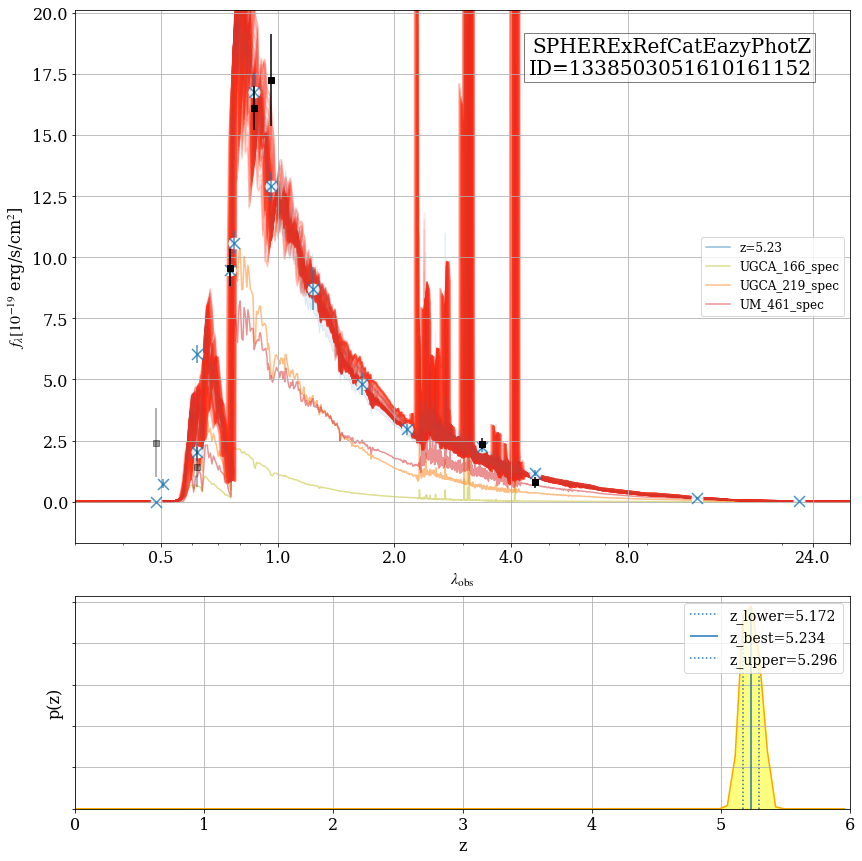

In [53]:
dummy = kasi_wrapper_fit_each_object_show_new(1329, ez, outfile='sed-vis-wow.png', \
                                              verbose=True, get_best_fit=False, prior=True, \
                                              beta_prior=False, fitter='nnls')

In [54]:
kasi_wrapper_fit_each_object_fast(1329, ez,get_best_fit=False, \
                                  prior=True, beta_prior=False, fitter='nnls')

[5.2335773, 5.1715517, 5.2962255]

>>Fitting time: 0.021 s 
>>idx_fit: 2224, zbest: 0.18524598, lnpmax: 3.61419
>>Valid Bands:  [ True  True  True  True  True False False False False False  True  True
  True  True  True]
>>NumValid Bands:  10
>>sed-vis-wow.png is saved on your current dirctory: /home/shong/work/sed-fit/pyspark-eazypy/notebook


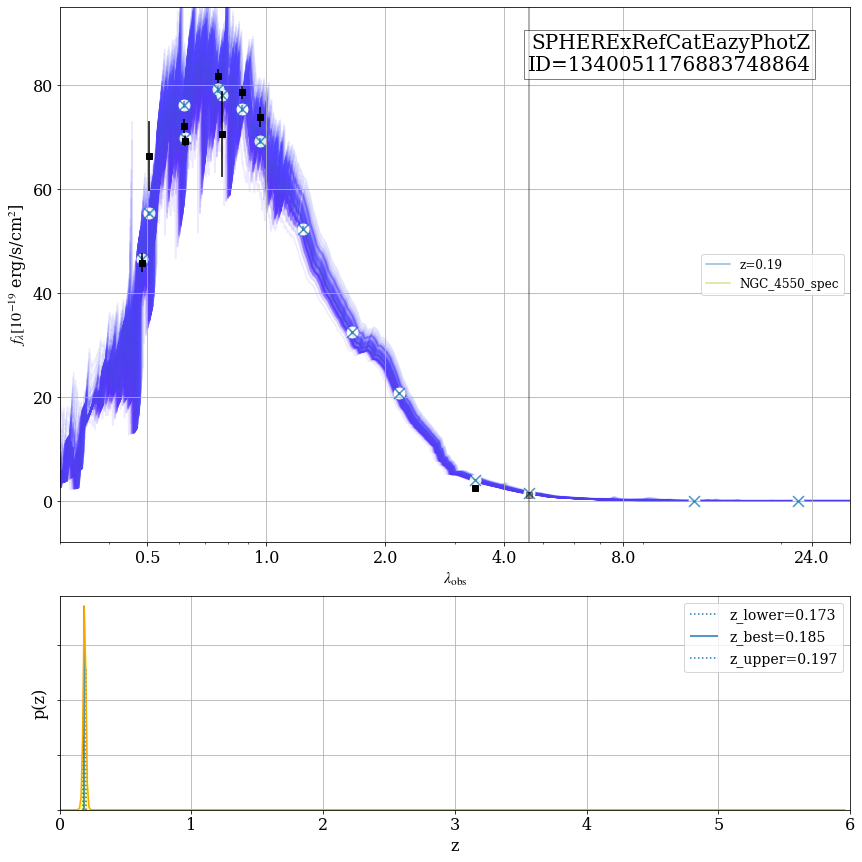

In [70]:
dummy = kasi_wrapper_fit_each_object_show_new(2224, ez, outfile='sed-vis-wow.png', \
                                              verbose=True, get_best_fit=False, prior=True, \
                                              beta_prior=False, fitter='nnls')

## Loop the photoz for all input objects

In [55]:
ez.NOBJ

102219

#### Single Thread

#### MultiThreads 

#### Version 1

```
########### Run EZ for all catalog objects 
listobjid = []
listzphotbest = []
listzphot16 = []
listzphot84 = []
```

```
from concurrent.futures import ThreadPoolExecutor

# Define a function to execute the loop body for a single index
def process_index(idx):
    zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(idx, ez, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')
    return zbest, zlower, zupper, ez.OBJID[idx]
```

```
%%time
# Define the number of categories
numcat = 1000

# Create a thread pool executor with a maximum of 10 threads
with ThreadPoolExecutor(max_workers=10) as executor:
    # Submit tasks to the thread pool for each index
    futures = [executor.submit(process_index, idx) for idx in range(numcat)]
    
    # Wait for all tasks to complete and retrieve results
    for future in futures:
        zbest, zlower, zupper, objid = future.result()
        listzphotbest.append(zbest)
        listzphot16.append(zlower)
        listzphot84.append(zupper)
        listobjid.append(objid)
```

> **Super Slow**

#### Version 2

In [56]:
########### Run EZ for all catalog objects 
listobjid = []
listzphotbest = []
listzphot16 = []
listzphot84 = []  

In [57]:
from concurrent.futures import ProcessPoolExecutor

# Define a function to execute the loop body for a single index
def process_index(idx):
    zbest, zlower, zupper = kasi_wrapper_fit_each_object_fast(idx, ez, get_best_fit=False, prior=True, beta_prior=False, fitter='nnls')
    return zbest, zlower, zupper, ez.OBJID[idx]

In [58]:
%%time
# Define the number of categories
#for testing only
#numcat = 30000
    
numcat = ez.NOBJ
# Create a process pool executor with a maximum of 10 processes
with ProcessPoolExecutor(max_workers=14) as executor:
    # Submit tasks to the process pool for each index
    futures = [executor.submit(process_index, idx) for idx in range(numcat)]
    
    # Wait for all tasks to complete and retrieve results
    for future in futures:
        zbest, zlower, zupper, objid = future.result()
        listzphotbest.append(zbest)
        listzphot16.append(zlower)
        listzphot84.append(zupper)
        listobjid.append(objid)

CPU times: user 16.2 s, sys: 3.04 s, total: 19.3 s
Wall time: 3min 37s


#### Running time analysis

In [59]:
(29*60.0 + 29.0) / (3.0*60.0 + 37.0)

8.152073732718893

#### Save the results as a pandas dataframe 

In [60]:
resultpdf = pd.DataFrame({'refid' : listobjid, 'zphot_16' : listzphot16, \
                          'zphot_best' : listzphotbest, 'zphot_84' : listzphot84})

In [61]:
resultpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102219 entries, 0 to 102218
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   refid       102219 non-null  int64  
 1   zphot_16    102219 non-null  float32
 2   zphot_best  102219 non-null  float32
 3   zphot_84    102219 non-null  float32
dtypes: float32(3), int64(1)
memory usage: 1.9 MB


In [62]:
resultpdf.head()

,refid,zphot_16,zphot_best,zphot_84
0,1333155099932884993,1.293205,1.386792,3.711236
1,1333155099932884994,0.552630,0.615994,2.974704
2,1333155100033548292,0.377059,5.049347,4.103621
3,1333155100067102720,0.615994,0.877517,0.934696
4,1333155100301983747,0.209190,4.640374,4.259049


In [63]:
resultpdf.tail()

,refid,zphot_16,zphot_best,zphot_84
102214,1404649748413022208,0.377059,4.584251,4.154913
102215,1404649748413022209,0.377059,5.049347,4.103621
102216,1404790481606410240,0.377059,5.049347,4.154913
102217,1404931219094765569,0.390899,5.049347,4.154913
102218,1404931219480641536,0.061784,0.061784,0.072455


In [64]:
#out_data_path = 

In [63]:
#resultfilename = hdfsheader+incatname.split(splitstr)[0]+'_pyarrow_table.parquet'

In [64]:
#table = pa.Table.from_pandas(resultpdf)
#pq.write_table(table, resultfilename)